In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [78]:
from Planet.data import PlanetDataCollection
from Planet.model import PlanetClassifer
from Planet.callbacks.scheduler import ParamScheduler
from Planet.callbacks.stats import AvgStatsCallback
from Planet.callbacks.training import LR_Find, CudaCallback
from Planet.callbacks.logger import Logger
from Planet.utils.basic import get_transforms, get_df, listify
from Planet.train import NNTrainer 
from torchvision import models
from pathlib import Path

In [79]:
import torch
from torch import nn
from torch import optim
from functools import partial
from Planet.utils.scheduler import sched_cos, combine_scheds

In [80]:
from Planet.callbacks.callback import Callback

In [81]:
from torch import nn
import torch.nn.functional as F

In [82]:
path = Path('/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/Planet')

In [83]:
tfms = get_transforms()

In [84]:
data = PlanetDataCollection.from_csv(path, 'train_v2.csv', 'train-jpg',
                           tfms, name_col='image_name', label_col='tags',
                           delimter=' ',bs=64,test_folder='test-jpg')

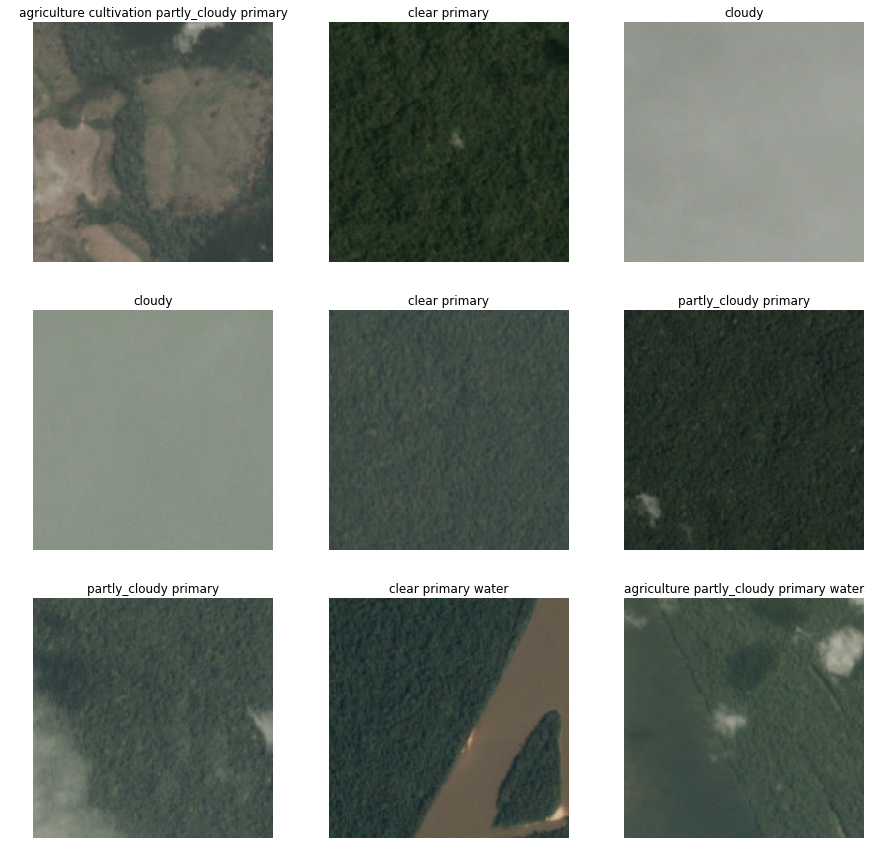

In [89]:
data.show()

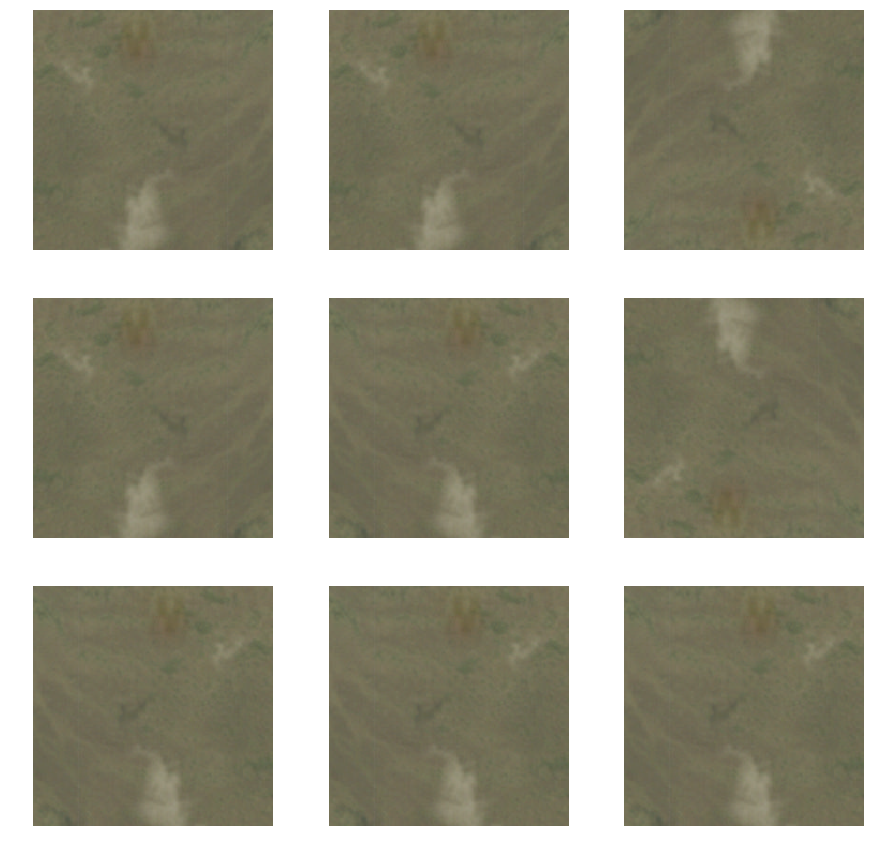

In [90]:
data.show_tfms()

In [85]:
def acc_thresh(out, yb, thresh):
    return ((out > thresh).float() == yb).float().mean()

In [86]:
def fbeta(out, yb, thresh=0.2, beta=2, eps=1e-9):
    beta2 = beta ** 2
    y_pred = (out > thresh).float()
    y_true = yb.float()
    
    TP = (y_pred * y_true).sum(dim=1)
    
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec  = TP/(y_true.sum(dim=1)+eps)
    
    res = (1+beta2)*((prec*rec)/((prec*beta2)+rec+eps))
    return res.mean()

In [87]:
arch = models.resnet50
model = PlanetClassifer(arch, output_sz=data.c)
loss_func = nn.BCEWithLogitsLoss()

In [88]:
wgts, biases = [],[]
for name,param in model.named_parameters():
    if ('weight' in name.split('.')):
        wgts.append(param)
    if ('bias' in name.split('.')):
        biases.append(param)

In [13]:
def pg_dicts(pgs):
    return [{'params': p} for p in pgs]

In [14]:
pgs = pg_dicts((wgts, biases))

In [15]:
opt = optim.Adam(pgs)

In [16]:
def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

In [17]:
def create_scheds(pct_first, sched_func, starts, highs, ends):
    phases = [pct_first, 1-pct_first]
    return [
        combine_scheds(phases, [sched_func(s,h), sched_func(h,e)])
        for s,h,e in zip(starts,highs,ends)
    ]

In [18]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None:
            x.sub_(self.sub)
        if self.maxv is not None:
            x.clamp_max_(self.maxv)
        return x
        

In [19]:
def convert_relu(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, GeneralRelu(leak=0.1, sub=0.4, maxv=6.))
        else:
            convert_relu(child)

In [20]:
convert_relu(model)

In [21]:
finder = NNTrainer(data, model, loss_func, opt, cb_funcs=[LR_Find, Logger, CudaCallback])

In [22]:
finder.fit(2)

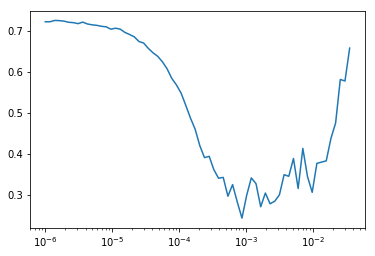

In [23]:
finder.logger.plot(skip_last=5)

In [24]:
scheds = create_scheds(0.3, sched_cos, (3e-5,3e-3), (3e-3,3e-2), (1e-5,1e-3))

In [25]:
trainer = NNTrainer(data, model, loss_func, opt, cbs=[ParamScheduler('lr', scheds),
                                                      AvgStatsCallback([partial(acc_thresh, thresh=0.2),
                                                                        partial(fbeta, beta=1)])],
                    cb_funcs=[Logger, CudaCallback])

In [26]:
trainer.fit(3)

     epoch        train_loss    train_acc_thresh   train_fbeta     valid_loss    valid_acc_thresh   valid_fbeta   time [min:sec] 
       0           0.662083        0.878785        0.621205        0.254700        0.909839        0.697054          03:31     


       1           0.251570        0.910155        0.696908        0.238689        0.913588        0.709555          03:41     


       2           0.232655        0.915075        0.719763        0.229948        0.914896        0.717151          03:46     


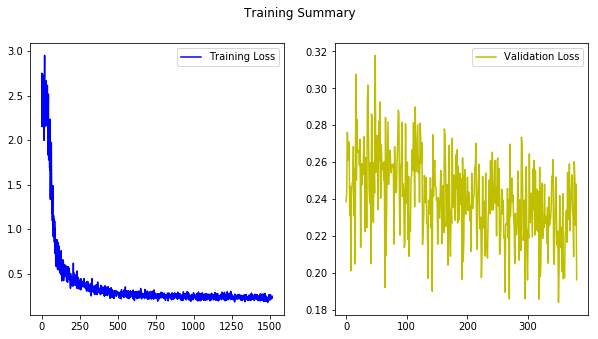

In [27]:
trainer.logger.plot_loss()

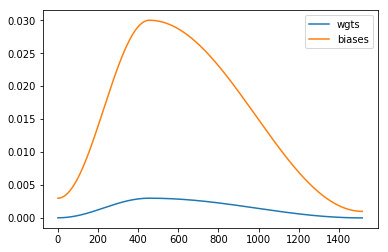

In [28]:
import matplotlib.pyplot as plt

plt.plot(trainer.logger.lrs[0])
plt.plot(trainer.logger.lrs[1])
plt.legend(['wgts','biases']);

In [29]:
trainer.model

PlanetClassifer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): GeneralRelu()
        (downsample): Sequential(
          (0):

In [70]:
a = trainer.data.train_ds.x[5]

In [71]:
torch.Tensor.ndim = property(lambda x: x.shape)

In [72]:
img = a

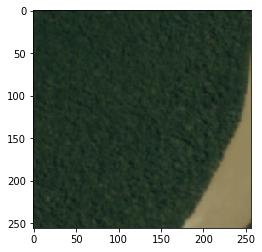

In [73]:
plt.imshow(img)

In [74]:
tfms = get_transforms()
tfms['train_display']

Compose(
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
)

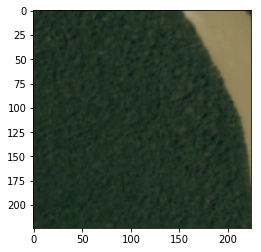

In [77]:
plt.imshow(tfms['train_display'](img))